In [1]:
%matplotlib inline

import sys
import pandas as pd
import os
import numpy as np

sys.path.insert(0, '..')
from glmhmm.glm_hmm import *
import matplotlib.pyplot as plt
from glmhmm.fitting import CrossValidation, GridSearch, mostProbSeq, FineTune, ShuffleControl
from preprocessing import utils2 as ut
from glmhmm.utils import find_last_non_nan_elements

# Load Data(file(s) -> t, x, y)

In [2]:
file = '../example_data/sub_455219/sub-455219_ses-20190805T152117_trial_events.csv'
# file = '../example_data/sub_455220/sub-455220_ses-20190731T151805_trial_events.csv'
# file = '../example_data/sub_480928/sub-480928_ses-20210128T133949_trial_events.csv'
df = pd.read_csv(file)
df

,id,start_time,stop_time,trial,photostim_onset,photostim_power,photostim_duration,trial_uid,task,task_protocol,...,go_start_times,go_stop_times,left_lick_times,photostim_start_times,photostim_stop_times,presample_start_times,presample_stop_times,right_lick_times,sample_start_times,sample_stop_times
0,0,0.0000,4.2505,1,NaN,NaN,NaN,1,audio delay,1,...,3.2469,[],[],[],[],0.5000,1.3969,3.7505,1.3969,2.0469
1,1,6.0362,11.0627,2,NaN,NaN,NaN,2,audio delay,1,...,9.1057,10.6057,"[9.5227, 9.7149, 9.8981, 10.0763, 10.2694, 10....",[],[],6.5362,7.2557,[],7.2557,7.9057
2,2,14.4301,19.7931,3,NaN,NaN,NaN,3,audio delay,1,...,18.1472,19.6472,"[16.1972, 18.2531, 18.3861, 18.5678, 18.7463, ...",[],[],14.9301,15.8211,[],"[15.8211, 16.2972]","[16.4711, 16.9472]"
3,3,21.6880,26.0036,4,NaN,NaN,NaN,4,audio delay,1,...,25.3289,[],"[23.1434, 23.3789]",[],[],22.1880,23.0483,"[22.1132, 22.3215, 22.5577, 25.5036, 25.7631, ...","[23.0483, 23.2434, 23.4789]","[23.6983, 23.8934, 24.1289]"
4,4,27.7900,34.1852,5,NaN,NaN,NaN,5,audio delay,1,...,32.5261,34.0261,"[29.7056, 29.9507, 29.9707, 31.2261, 32.6452, ...",[],[],28.2900,29.1176,[],"[29.1176, 29.8056, 30.0507]","[29.7676, 30.4556, 30.7007]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,556,3782.4033,3787.1798,557,NaN,NaN,NaN,557,audio delay,1,...,3785.5037,3787.0037,"[3785.6398, 3785.758, 3785.8952, 3786.054, 378...",[],[],3782.9033,3783.6537,[],3783.6537,3784.3037
557,557,3789.4584,3794.3493,558,NaN,NaN,NaN,558,audio delay,1,...,3792.6268,3794.1268,[],[],[],3789.9584,3790.7768,"[3792.8093, 3792.9349, 3793.0971, 3793.2334, 3...",3790.7768,3791.4268
558,558,3796.6298,3801.6103,559,NaN,NaN,NaN,559,audio delay,1,...,3799.8264,3801.3264,[],[],[],3797.1298,3797.9764,"[3800.0703, 3800.2427, 3800.3874, 3800.5254, 3...",3797.9764,3798.6264
559,559,3803.8857,3808.9316,560,NaN,NaN,NaN,560,audio delay,1,...,3807.1176,3808.6176,[],[],[],3804.3857,3805.2676,"[3807.3916, 3807.5498, 3807.7074, 3807.8444, 3...",3805.2676,3805.9176


In [3]:
folder = "../example_data/sub_455219"
# folder = "../example_data/sub_479121"

# Fit GLM-HMM

In [5]:
lls_train, lls_test, A_all, w_all, train_size, test_size = CrossValidation([folder, folder], 3, True, 3)

sess [   0  550 1146 1743 2463 3013 3609 4206 4926]


KeyboardInterrupt: 

In [127]:
# averaged marginal loglikelihood across time
np.mean(lls_train)/train_size, np.mean(lls_test)/test_size

(-0.7216551129961085, -0.7252467435941617)

In [171]:
# exclude ignore
opt_np, opt_lt, avg_test, avg_train, std_test, std_train, train_sz, test_sz = GridSearch(folder,
                                                                                         True)


nprev 0 num_latent 1
Init 1
train ll -1356.2390049588469
test ll -156.5073711156041
Cross Validation 1 complete
train ll -1358.692814774014
test ll -154.0535613004368
Cross Validation 2 complete
train ll -1364.745266798749
test ll -148.00110927570188
Cross Validation 3 complete
train ll -1353.0589889339474
test ll -159.6873871405035
Cross Validation 4 complete
train ll -1362.336329790679
test ll -150.41004628377212
Cross Validation 5 complete
train ll -1360.534541931016
test ll -152.2118341434351
Cross Validation 6 complete
train ll -1364.5695851563105
test ll -148.1767909181405
Cross Validation 7 complete
train ll -1365.1602750693105
test ll -147.58610100514068
Cross Validation 8 complete
train ll -1363.108372228884
test ll -149.63800384556714
Cross Validation 9 complete
train ll -1367.5237936055996
test ll -145.22258246885144
Cross Validation 10 complete
Init 2
train ll -2449.135845970552
test ll -269.0573646569892
Cross Validation 1 complete
train ll -2465.50804819563
test ll -252.

KeyboardInterrupt: 

In [130]:
opt_np, opt_lt, avg_test, avg_train, std_test, std_train, train_sz, test_sz

(2,
 6,
 array([[-47.44032762, -40.28779572, -39.66827109, -36.21426337,
         -36.26564264, -36.41095582, -36.21586518],
        [-42.3870323 , -43.2000927 , -36.91246523, -37.35826014,
         -36.54403125, -38.00659089, -35.39671587],
        [-40.1048157 , -42.3529344 , -36.17847966, -35.05701529,
         -37.00941368, -34.52231302, -36.07901717],
        [-47.19631362, -40.15921831, -35.77271226, -37.20531426,
         -36.40765386, -37.78435377, -36.46583369],
        [-38.30852637, -42.30614702, -37.88557361, -36.63450129,
         -36.67040046, -35.26568917, -36.18774655]]),
 array([[-436.11943976, -368.73697609, -362.23672896, -331.01316763,
         -331.7672264 , -332.64116707, -330.49808624],
        [-385.34021633, -391.02339552, -335.15904463, -338.87246266,
         -331.94569354, -345.14737164, -319.95411945],
        [-363.36603426, -382.68170761, -324.93941567, -316.02511288,
         -331.81488255, -308.56151942, -323.33111365],
        [-424.76682262, -360.3019

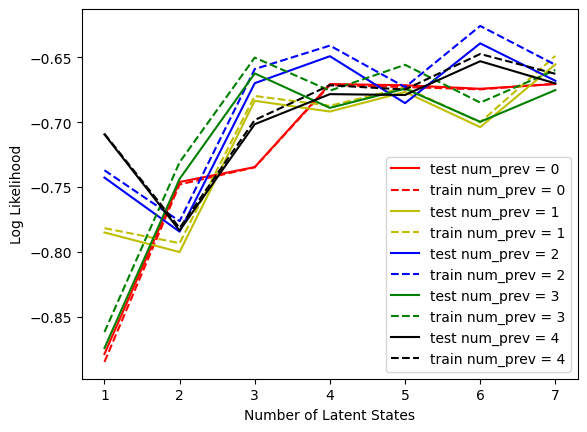

In [131]:
num_np, num_numlt = avg_test.shape
colors = ['r','y','blue','green', 'black', 'm', 'gold', 'gray','pink']
for rowid in range(num_np):
    x = range(1,num_numlt + 1)
    plt.plot(x, avg_test[rowid]/test_sz, color = colors[rowid],label = f"test num_prev = {rowid}")
    plt.plot(x, avg_train[rowid]/train_sz, '--',color = colors[rowid], label = f"train num_prev = {rowid}")
plt.ylabel("Log Likelihood")
plt.xlabel("Number of Latent States")
plt.legend()

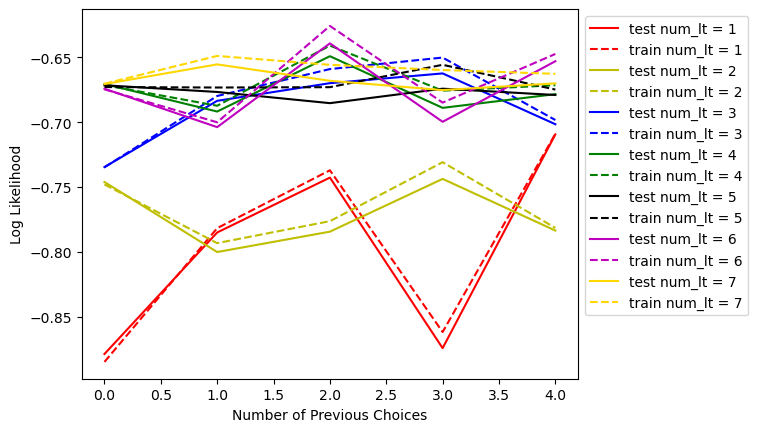

In [134]:
for colid in range(num_numlt):
    x = range(0,num_np)
    plt.plot(x, avg_test[:,colid]/test_sz, color = colors[colid],label = f"test num_lt = {colid + 1}")
    plt.plot(x, avg_train[:,colid]/train_sz, '--',color = colors[colid], label = f"train num_lt = {colid + 1}")
plt.ylabel("Log Likelihood")
plt.xlabel("Number of Previous Choices")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
# include ignore (worse than exluding ignore)
opt_np, opt_lt, avg_test, avg_train, std_test, std_train, train_sz, test_sz = GridSearch(file, False)

In [156]:
np.exp(-0.65)


0.522045776761016

# Analysis on a single model

## Fit the model

In [4]:
# Fit a model on all data
# Choose nprev = 2, num_latent = 3, exclude ignore
nprev = 2
num_latent = 3
exig = True


lls_train, lls_test, ll0, A_all, w_all, pi0_all, train_size, test_size = CrossValidation(path=file,#None,
                                                                           nprev=nprev, exig=exig, num_latent=num_latent)

Converged after 95 iterations
Converged after 42 iterations
Converged after 105 iterations
Converged after 36 iterations
Converged after 41 iterations
Converged after 38 iterations
Converged after 104 iterations
Converged after 129 iterations
Converged after 42 iterations
Converged after 50 iterations
Converged after 34 iterations
Converged after 18 iterations
Converged after 20 iterations
Converged after 17 iterations
Converged after 18 iterations
Converged after 18 iterations
Converged after 20 iterations
Converged after 25 iterations
Converged after 22 iterations
Converged after 16 iterations
Converged after 43 iterations
Converged after 32 iterations
Converged after 118 iterations
Converged after 113 iterations
Converged after 129 iterations
Converged after 114 iterations
Converged after 110 iterations
Converged after 123 iterations
Converged after 27 iterations
Converged after 36 iterations


In [19]:
# w:KxDxC
print(lls_test)
max_index = np.unravel_index(np.argmax(lls_test), lls_test.shape)
(i,j) = max_index
A = A_all[i,j]
w_ = w_all[i,j]

[[-32.5265579  -31.72203511 -27.08954861 -26.82144447 -24.12626585
  -25.70347286 -23.22617981 -27.3205394  -32.13654631 -30.69550307]
 [-32.53272978 -31.61734492 -27.00895062 -26.68670557 -24.16636382
  -25.53562757 -23.28818159 -27.20950833 -32.34951407 -31.25717963]
 [-32.59263649 -31.68646588 -27.08908767 -26.92303672 -24.22517136
  -25.7892326  -23.22940537 -27.32046416 -32.13729942 -30.842679  ]]


In [20]:
print("w_", w_)
ll,A,w,pi0,X,y,N,K,D,C = FineTune(path=file, nprev=nprev, exig=exig, num_latent=num_latent, A_init = A,w_init = w_)
print("w", w)
print("w_", w_)

w_ [[[ 0.          0.1460879 ]
  [ 0.          0.81187328]
  [ 0.          0.29575293]
  [ 0.         -0.15900451]
  [ 0.          1.19300154]]

 [[ 0.         -0.2741616 ]
  [ 0.         -0.20414222]
  [ 0.         -0.13730761]
  [ 0.         -0.28620105]
  [ 0.          0.02633919]]

 [[ 0.         -1.91137656]
  [ 0.          2.84721175]
  [ 0.          0.42458876]
  [ 0.          0.1230228 ]
  [ 0.         -0.02986137]]]
Converged after 138 iterations
w [[[  0.          -0.72110879]
  [  0.           2.05940772]
  [  0.           0.7473558 ]
  [  0.           0.09129976]
  [  0.          10.91268746]]

 [[  0.           8.30239563]
  [  0.         -19.88418045]
  [  0.         -46.95953746]
  [  0.         -15.08301391]
  [  0.          34.47262133]]

 [[  0.          -2.33060366]
  [  0.           3.31488246]
  [  0.           0.60091565]
  [  0.           0.29007179]
  [  0.          -0.10274006]]]
w_ [[[ 0.          0.1460879 ]
  [ 0.          0.81187328]
  [ 0.          0.29575

In [7]:
np.exp(ll/len(X))

array([0.61157227])

In [8]:
# Emission Probablity matrix
phi = np.zeros((N,K,C))
for i in range(K):
    p = np.exp(X @ w[i,:,:])
    phi[:,i,:] = np.divide(p.T,np.sum(p,axis=1)).T

## Most Probable Sequence of States

In [9]:
bestpath = mostProbSeq(y, A, pi0, phi)

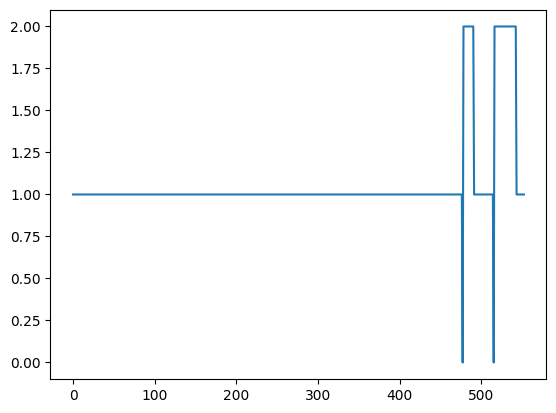

In [10]:
x = np.arange(len(bestpath))
plt.plot(x, bestpath)

## Most Probable state over timespan

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

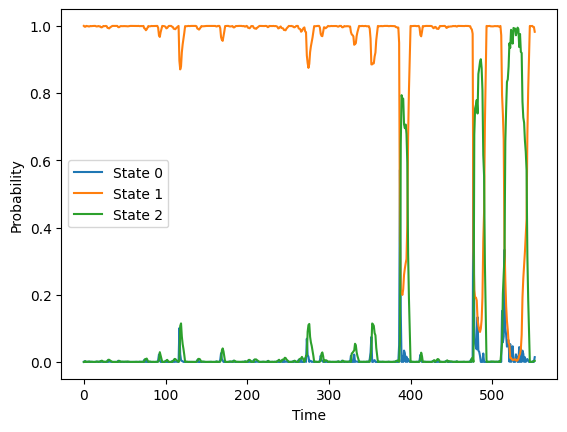

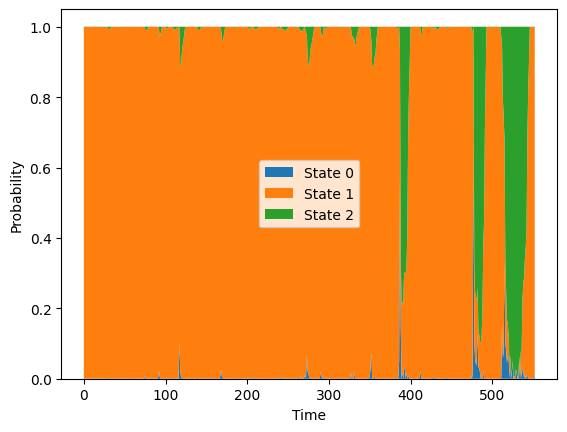

In [11]:
from glmhmm.fitting import statesProb


pBack = statesProb(y, A, pi0, phi, vis = True)
states = np.argmax(pBack, axis = 1)
states


# Visualization

[[2.05044635e-35 9.99999997e-01 2.78577151e-09]
 [3.60433538e-03 2.70695975e-35 9.96395665e-01]
 [5.16832867e-09 1.06666441e-07 9.99999888e-01]]


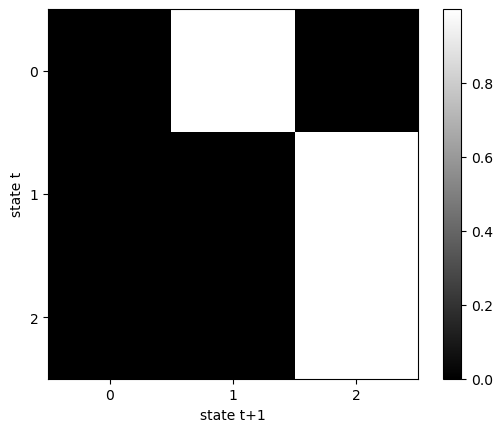

In [210]:
# Transition matrix
print(A)
plt.imshow(A, cmap = 'gray')
plt.xlabel('state t+1')
plt.ylabel('state t')
plt.xticks(np.arange(A.shape[0]))
plt.yticks(np.arange(A.shape[0]))
plt.colorbar()

In [211]:
# Weights
c1 = w[:,:,0]
c2 = w[:,:,1]
c1, c2 # c1 should be all zeros, so that it is bernoulli distribution

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[-0.53, -0.96,  0.73, -0.38,  0.29],
        [-0.68, -0.2 , -0.4 , -0.17, -0.48],
        [-0.53, -0.11,  0.2 ,  0.1 , -0.35]]))

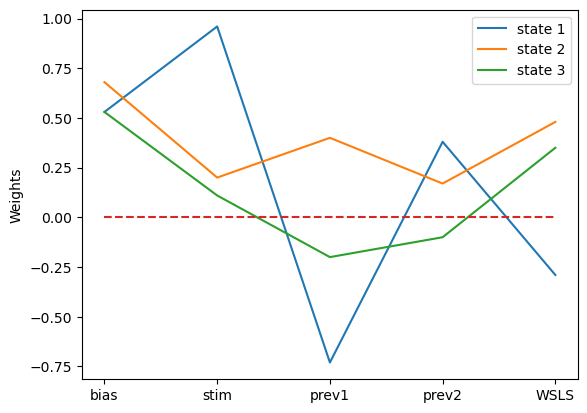

In [212]:
weight = -c2
state1 = weight[0,:]
state2 = weight[1,:]
state3 = weight[2,:]
x = np.arange(1, len(state1) + 1)
plt.plot(x, state1, label = 'state 1')
plt.plot(x, state2, label = 'state 2')
plt.plot(x, state3, label = 'state 3')
plt.plot(x, [0]*len(x), '--')
plt.xticks(x, labels = ['bias', 'stim','prev1', 'prev2','WSLS'])
plt.ylabel("Weights")
plt.legend()

In [ ]:
# Emission Probability of class 1
fig, axs = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)

for k in range(0, K):
    phi = np.exp(X@w[k,:,:])
    phi = np.divide(phi.T,np.sum(phi,axis=1)).T
    axs[k].set_title(f'State {k+1}')
    axs[k].plot(range(1, len(phi)+1), phi[:,0], label=f'state {k+1}')
    axs[k].set_xlabel('N')
    axs[k].set_ylabel('Probability')

# Shuffle the data

Compare the fitting of three kinds of data

(1) unshuffled data

(2) shuffle the rows of data. In other words, shuffle the time to break the continuity. 
    The relation between x and y doesn't change
    
(3) only shuffle the y, while keep x unchanged. 

In [ ]:
org_data = Dataloader_sess(file, nprev = 2, exig = True)

In [ ]:
A_orgs = []
A_ts = []
w_orgs = []
w_ts = []
for i in range(10):
    # Get X and y
    shuffled_indices = np.random.permutation(org_data.shape[0])
    shfl_time_data = org_data[shuffled_indices, :] # shuffle the rows of the matrix/shuffle the time
    shfl_y_data = np.hstack((org_data[:, :-1], org_data[shuffled_indices, -1:])) # only shuffle the y
    
    X_org = org_data[:,1:-1]
    y_org = org_data[:,-1]
    X_shf_t = shfl_time_data[:,1:-1]
    y_shf_t = shfl_time_data[:,-1]
    X_shf_y = shfl_y_data[:,1:-1]
    y_shf_y = shfl_y_data[:,-1]

    # Fit model for each pair of X and y
    A_init,w_init,pi_init = model.generate_params() 
    lls_org,A_org,w_org,_ = model.fit(y_org,X_org,A_init,w_init)
    ll_org = find_last_non_nan_elements(lls_org.reshape(1, -1))
    
    A_init,w_init,pi_init = model.generate_params() 
    lls_t,A_t,w_t,_ = model.fit(y_shf_t,X_shf_t,A_init,w_init)
    ll_t = find_last_non_nan_elements(lls_t.reshape(1, -1))
    
    A_init,w_init,pi_init = model.generate_params() 
    lls_y,_,_,_ = model.fit(y_shf_y,X_shf_y,A_init,w_init)
    ll_y = find_last_non_nan_elements(lls_y.reshape(1, -1))

    A_orgs.append(A_org)
    A_ts.append(A_t)
    w_orgs.append(w_org)
    w_ts.append(w_t)
    
    print(ll_org, ll_t, ll_y)

In [ ]:
A_orgs[0], A_ts[0]

In [ ]:
A_orgs[4], A_ts[4]